In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from autograd.scalar.engine import Value
from autograd.scalar.graphic import draw_dot
from autograd.scalar.nn import MLP, cross_entropy_loss
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
n = x1w1 + x2w2; n.label = 'x1w1 + x2w2'

n = n + b; n.label = 'n'

# activation
o = n.tanh(); o.label = 'o'

# target
target = Value(2.0, label='target')

# loss
diff = o - target; diff.label = 'o - target'

loss = diff ** 2; loss.label = 'loss'

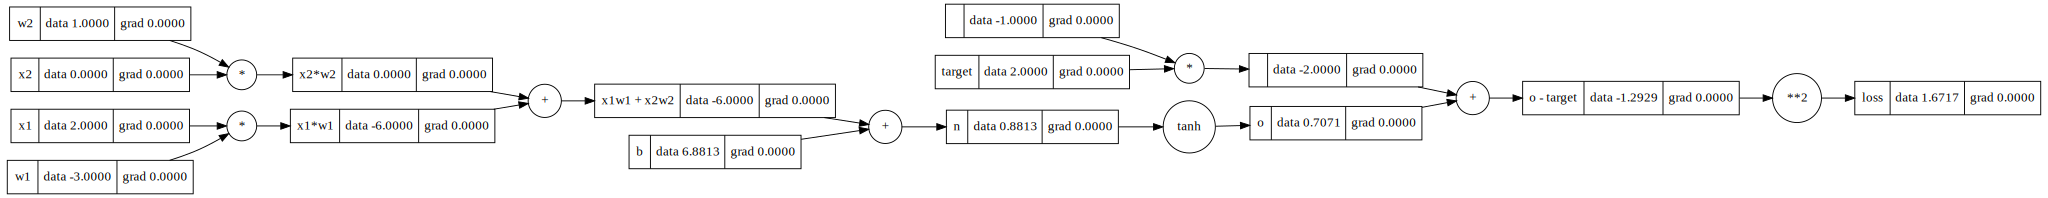

In [3]:
draw_dot(loss)

In [4]:
loss.backward()

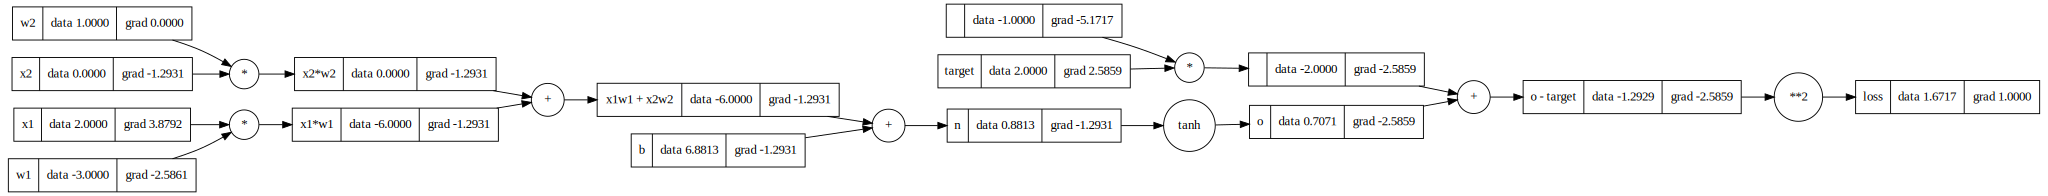

In [5]:
draw_dot(loss)

### Building a neural net for classification

In [23]:
np.random.seed(1337)
random.seed(1337)

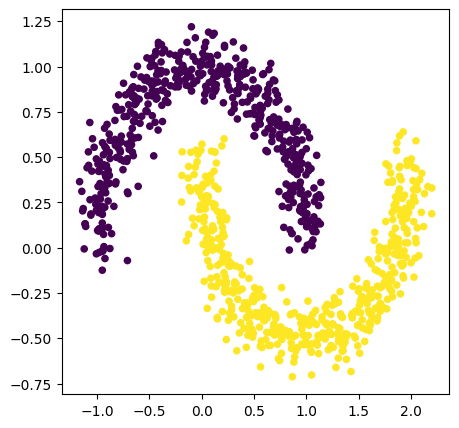

In [66]:
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1)

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='viridis')

In [77]:
# Initialize a model 
model = MLP(2, [16, 16, 2])
print(model)
print("Number of parameters", len(model.parameters()))

MLP(
  (0): ReLULayer(in=2, out=16)
  (1): ReLULayer(in=16, out=16)
  (2): LinearLayer(in=16, out=2)
)
Number of parameters 354


In [78]:
# Training loop (PyTorch-style)
batch_size = 128  # None for full batch, or set to e.g., 32 for mini-batch
num_epochs = 60
learning_rate = 1

train_losses = []
train_accs = []

for epoch in range(num_epochs):
    
    # Sample a batch
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # Convert data to Value objects
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward pass
    y_pred = list(map(model, inputs))
    
    # Compute loss (mean cross-entropy over the batch)
    losses = [cross_entropy_loss(logits, int(label)) for logits, label in zip(y_pred, yb)]
    data_loss = sum(losses[1:], losses[0]) * (1.0 / len(losses))

    # L2 regularization
    lambda_reg = 1e-4
    l2_reg = sum((p * p for p in model.parameters()), Value(0.0))

    # Final loss
    total_loss = data_loss + lambda_reg * l2_reg

    # Compute accuracy
    acc = sum(
        (logits[1].data > logits[0].data) == bool(label)
        for logits, label in zip(y_pred, yb)
    ) / len(yb)
    
    # Zero gradients
    model.zero_grad()
    
    # Backward pass
    total_loss.backward()
    
    # Update weights (SGD)
    lr = learning_rate - 0.9 * learning_rate * epoch / num_epochs
    for p in model.parameters():
        p.data -= lr * p.grad
    
    # Record metrics
    train_losses.append(total_loss.data)
    train_accs.append(acc)

    # Log progress
    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | Loss: {total_loss.data:.4f} | Accuracy: {acc*100:.2f}%")


Epoch   0 | Loss: 1.1422 | Accuracy: 46.09%
Epoch   5 | Loss: 0.4017 | Accuracy: 75.78%
Epoch  10 | Loss: 0.2947 | Accuracy: 85.16%
Epoch  15 | Loss: 0.2280 | Accuracy: 88.28%
Epoch  20 | Loss: 0.2015 | Accuracy: 92.19%
Epoch  25 | Loss: 0.2279 | Accuracy: 92.19%
Epoch  30 | Loss: 0.1911 | Accuracy: 91.41%
Epoch  35 | Loss: 0.2467 | Accuracy: 90.62%
Epoch  40 | Loss: 0.1395 | Accuracy: 95.31%
Epoch  45 | Loss: 0.2009 | Accuracy: 92.19%
Epoch  50 | Loss: 0.1844 | Accuracy: 92.19%
Epoch  55 | Loss: 0.1783 | Accuracy: 92.19%


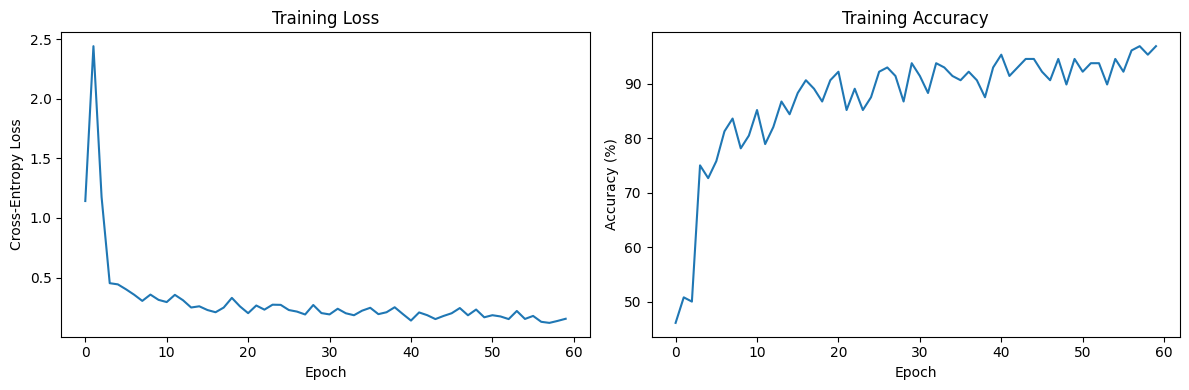

In [79]:
# Plot training loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross-Entropy Loss")

ax2.plot([a * 100 for a in train_accs])
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


(-1.7127033770644031, 2.037296622935597)

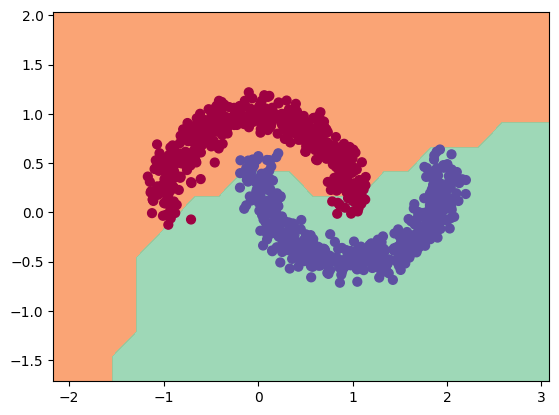

In [80]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[1].data > s[0].data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
